In [1]:
import importlib

import RedFunciones.visualizacion as visualizacion
import RedFunciones.Generador as Generador
import RedFunciones.Discriminador as Discriminador
import RedFunciones.auxiliares as auxiliares
import RedFunciones.DataloaderVol as DataloaderVol
import RedFunciones.Checkpoint as Checkpoint

importlib.reload(auxiliares)
importlib.reload(visualizacion)
importlib.reload(Generador)
importlib.reload(Discriminador)
importlib.reload(DataloaderVol)
importlib.reload(Checkpoint)

import Auxiliares.BinaryAccuracy as bin_acc

import json

import PrePross.pre_pross as prpr
import PrePross.grifflin as grifflin
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import importlib
import pandas as pd
importlib.reload(prpr)

import torch
from torch import nn
from tqdm.auto import tqdm 

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST 

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import os
cwd = os.getcwd()
print(cwd)

cuda0 = torch.device('cuda:1')
cpu = 'cpu'
device = torch.device(cuda0 if torch.cuda.is_available() else cpu)
print(torch.cuda.is_available())
print(torch.cuda.device_count())


/home/fgrijalva/RedVolcanica/RedVolcanica
True
4


In [ ]:
limite_snr = 10

base_vt=prpr.open_bdd('Data/VT_IGEPN_1.json')
base_lp=prpr.open_bdd('Data/LP_IGEPN_1.json')
basef = pd.concat([base_vt, base_lp])
base=prpr.extraer_señales(basef, '')
prpr.normalizar_tamanio_base(base, 83)
prpr.normalizar_muestras(base, 8192/2)
base_rms=prpr.quitar_dc(basef)
base = base_rms
base = prpr.drop_data_na(base)
base = prpr.drop_data_ruido(base, limite_snr)
base = prpr.normailizar_muestras(base)
prpr.guardar_base_h5(base,129,33, nombre='baseSR10')


criterion: the loss function

n_epochs: the number of times you iterate through the entire 
dataset when training

z_dim: the dimension of the noise vector

display_step: how often to display/visualize the images

batch_size: the number of images per forward/backward pass

lr: the learning rate


device: the device type

In [2]:
seed = 0
torch.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)  
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = True

In [3]:
display_step = 50

h5_filename = cwd + '/baseh5/baseSR10.h5'
nombre = 'master'
nombre_carga = 'final15.pt'

z_dim = 64
n_epochs = 15
batch_size = 12

lrg = 0.00009
beta_1_g = 0.5
beta_2_g = 0.999
repeats_g = 3

lrd = 0.0002
beta_1_d = 0.5
beta_2_d = 0.999
d_repeats = 1

guardar = False
cargar = True
save_steep = 1

regularizaM = True
reg_lambda = 0.001

In [4]:
criterion = nn.BCEWithLogitsLoss()
mnist_shape = (1, 129, 33) 
n_classes = 2
mean = 0
std = 1
epoch_temp = -1
gen_loss_temp = torch.empty([])
disc_loss_temp = torch.empty([])

In [5]:
transform = transforms.Compose([])    
myData = DataloaderVol.VolcanoDatasetH5(h5_filename, transform)

dataloader = DataLoader(
    myData,
    batch_size=batch_size,
    shuffle=True)

In [6]:
generator_input_dim, discriminator_im_chan = auxiliares.get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generador.Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lrg)
disc = Discriminador.Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lrd)
gen = gen.apply(auxiliares.weights_init)
disc = disc.apply(auxiliares.weights_init)

disc.train()
gen.train()
        
metric = bin_acc.BinaryAccuracy()

In [7]:
if cargar:
    compelto = Checkpoint.DIRECTORY + nombre_carga
    checkpoint = torch.load(compelto)
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])
    gen_opt.load_state_dict(checkpoint['gen_opt'])
    disc_opt.load_state_dict(checkpoint['disc_opt'])
    epoch_temp = checkpoint['epoch']
    gen_loss_temp = checkpoint['gen_loss']
    disc_loss_temp = checkpoint['dis_loss']
    print('Modelo cargado')
    print('epoch: ' + str(epoch_temp))

Modelo cargado
epoch: 14


In [8]:
cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_losses_real = []
discriminator_losses_fake = []
metric_real = []
metric_fake = [] 

for epoch in range(epoch_temp + 1, n_epochs):
    print('Epoch: ' + str(epoch))
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        one_hot_labels = auxiliares.get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])
        disc_opt.zero_grad()
        fake_noise = auxiliares.get_noise(cur_batch_size, z_dim, device=device)
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen.forward(noise_and_labels) #no usar     
        #fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar
        fake_image_and_labels = auxiliares.combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = auxiliares.combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)               
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        metric_fake += [metric(disc_fake_pred, torch.zeros_like(disc_fake_pred)).item()]
        metric_real += [metric(disc_real_pred, torch.ones_like(disc_real_pred)).item()]       
        disc_loss = ((disc_fake_loss + disc_real_loss)/2)       
        if regularizaM:
            l2_reg = None
            for W in disc.parameters():
                if l2_reg is None:
                    l2_reg = W.norm(2)
                else:
                    l2_reg = l2_reg + W.norm(2)
            disc_loss = disc_loss +  l2_reg * reg_lambda         
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 
        discriminator_losses_real += [disc_real_loss.item()]
        discriminator_losses_fake+= [disc_fake_loss.item()]
        discriminator_losses += [disc_loss.item()]
        mean_iteration_gen_loss = 0
        for _ in range(repeats_g):
            gen_opt.zero_grad()
            fake_noise_2 = auxiliares.get_noise(cur_batch_size, z_dim, device=device)       
            noise_and_labels_2 = auxiliares.combine_vectors(fake_noise_2, one_hot_labels)
            fake_2 = gen(noise_and_labels_2)   
            fake_image_and_labels = auxiliares.combine_vectors(fake_2, image_one_hot_labels)
            disc_fake_pred = disc(fake_image_and_labels)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            mean_iteration_gen_loss += gen_loss.item() / repeats_g    
            gen_loss.backward()
            gen_opt.step()
        generator_losses += [mean_iteration_gen_loss]
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            print(f"Espectrogramas Generados")
            visualizacion.show_tensor_images(torch.transpose(fake, 2, 3), size=(1, 129, 33), num_images=1)
            print(f"Espectrogramas Reales")
            visualizacion.show_tensor_images(torch.transpose(real, 2, 3), size=(1, 129, 33), num_images=1)
            
            visualizacion.show_time_domine_images(torch.transpose(real, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = True)
            visualizacion.show_time_domine_images(torch.transpose(fake, 2, 3), size=(1, 129, 33), std=std, mean=mean, real = False)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            
            plt.show()
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses_fake[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss Fake"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses_real[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss Real"
            )
            plt.legend()
            
            plt.show()
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_real[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC REAL"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(metric_fake[:num_examples]).view(-1, step_bins).mean(1),
                label="METRIC FAKE"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Red Funcionando")
        cur_step += 1 
    if((guardar and epoch % save_steep == 0) or epoch == n_epochs - 1):
        Checkpoint.save_weighs(gen, disc, gen_opt, disc_opt, epoch, gen_loss, disc_loss, nombre)
        print('epoch guardada')                

In [9]:
gen.eval()
disc.eval()

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(13, 4), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(13, 4), stride=(2, 2))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(13, 4), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(13, 4), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(13, 4), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Sequential(
      (0): Conv2d(256, 512, kernel_size=(13, 4), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (6): Sequential(
      (0): Conv2d(512, 1, kernel_size=(5, 2), stride=(2, 2))
    )
  )
)

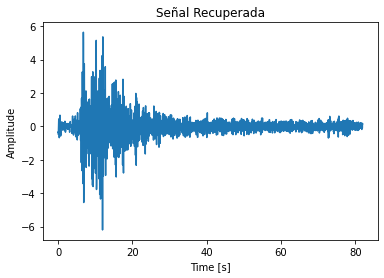

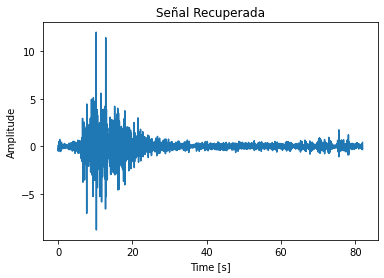

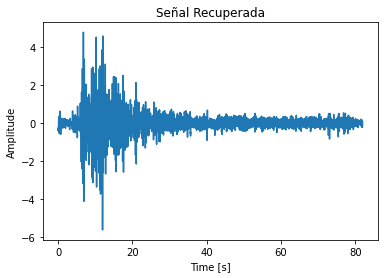

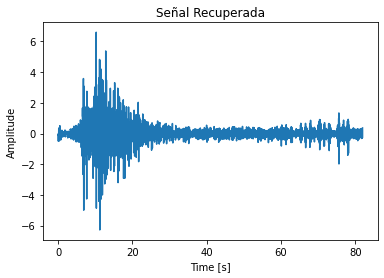

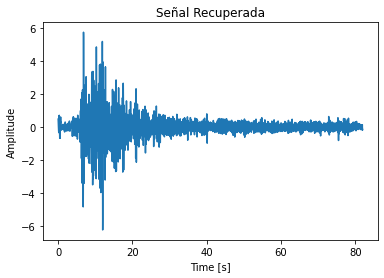

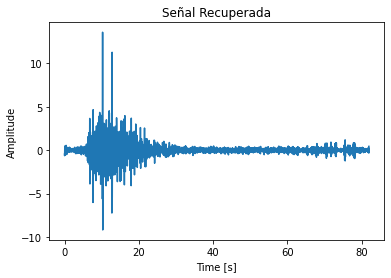

In [10]:
import PrePross.grifflin as grifflin
import numpy as np

examples = 3

for i in range(examples):
    x = torch.tensor([1])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    fake = fake.cpu().detach().numpy() 
    fake = fake * std + mean
    samplerate = 50
    timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
    muestra_rec = np.squeeze(muestra_rec)
    tamaño = len(muestra_rec) / samplerate
    time = np.linspace(0., tamaño, len(muestra_rec))
    plt.plot(time,muestra_rec)
    plt.title("Señal Recuperada")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    x = torch.tensor([0])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    fake = fake.cpu().detach().numpy() 
    fake = fake * std + mean
    samplerate = 50
    timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
    muestra_rec = np.squeeze(muestra_rec)
    tamaño = len(muestra_rec) / samplerate
    time = np.linspace(0., tamaño, len(muestra_rec))
    plt.plot(time,muestra_rec)
    plt.title("Señal Recuperada")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    

In [11]:
from torchvision.utils import save_image

n = 4792
for i in range(n):
    x = torch.tensor([1])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    nombre = 'img/fake/lp/img'+str(i)+'.png'
    save_image(fake, nombre)

n = 1358
for i in range(n):
    x = torch.tensor([0])
    one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
    fake_noise = auxiliares.get_noise(1, z_dim, device=device)
    noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels)
    nombre = 'img/fake/vt/img'+str(i)+'.png'
    save_image(fake, nombre)

n = 1000
for i in range(n):
    ruidoplano = np.random.normal(size = 129*33)
    ruido = ruidoplano.reshape((129, 33))
    nombre = 'img/ruido/img'+str(i)+'.png'
    sample = torch.from_numpy(ruido)
    save_image(sample, nombre)

n = myData.__len__()
c =0
cd=0
for i in range(n):
    sample, tag = myData.__getitem__(i)
    nombre = ''
    if tag == 0:
        nombre = 'img/real/vt/img'+str(i)+'.png'
        save_image(sample, nombre)
    if tag == 1:
        nombre = 'img/real/lp/img'+str(i)+'.png'
        save_image(sample, nombre)

In [12]:
!python -m pytorch_fid img/fake/vt img/real/vt
!python -m pytorch_fid img/fake/lp img/real/lp
!python -m pytorch_fid img/fake/vt img/ruido
!python -m pytorch_fid img/fake/lp img/ruido
!python -m pytorch_fid img/fake/vt img/fake/lp

100%|███████████████████████████████████████████| 28/28 [00:03<00:00,  8.84it/s]
FID:  196.73561517245668
100%|███████████████████████████████████████████| 97/97 [00:09<00:00, 10.76it/s]
FID:  138.3013263065083
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.60it/s]
FID:  471.49567650073254
100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.01it/s]
FID:  463.39638765872616
100%|███████████████████████████████████████████| 96/96 [00:08<00:00, 11.49it/s]
FID:  53.89539915440097


In [13]:
#Generar Base de datos de n muestras

In [10]:
import h5py

fileName = 'baseh5/' + 'base_final' + '.h5'
numOfSamples = 20000
with h5py.File(fileName, "w") as out:
    dt = h5py.special_dtype(vlen=str)
    out.create_dataset("X_esp", (numOfSamples, 129, 33), dtype='float64')
    out.create_dataset("X_time", (numOfSamples, 4096, 1), dtype='float64')
    out.create_dataset("X_tag", (numOfSamples, 1), dtype=dt)


In [11]:
with h5py.File(fileName, "a") as out:
    for i in range(10000):
        x = torch.tensor([0])
        one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
        fake_noise = auxiliares.get_noise(1, z_dim, device=device)
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        fake = fake.cpu().detach().numpy() 
        fake = fake * std + mean
        samplerate = 50
        timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
        out['X_esp'][i , ...] = fake
        out['X_time'][i, ...] = np.squeeze(muestra_rec).reshape(4096, 1)
        out['X_tag'][i, ...] = 'VT'        
        x = torch.tensor([1])
        one_hot_labels = auxiliares.get_one_hot_labels(x.to(device), n_classes)
        fake_noise = auxiliares.get_noise(1, z_dim, device=device)
        noise_and_labels = auxiliares.combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        fake = fake.cpu().detach().numpy() 
        fake = fake * std + mean
        timee, muestra_rec=grifflin.reconstruir_señal_generador(fake, 1000, samplerate)
        out['X_esp'][i + 10000, ...] = fake
        out['X_time'][i + 10000, ...] = np.squeeze(muestra_rec).reshape(4096, 1)
        out['X_tag'][i + 10000, ...] = 'LP'
        if(i%10 == 0):
            print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2